# ***IMPORTS***

In [ ]:
%%capture
!pip install -U "tensorflow-text==2.15.*"
!pip install "tf-models-official==2.15.*"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import re, string
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
tf.get_logger().setLevel('ERROR')

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


# ***LOADING DATASET & PLOTTING***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Lab Project/Corona_NLP.csv',encoding='latin1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


<Axes: xlabel='count', ylabel='Sentiment'>

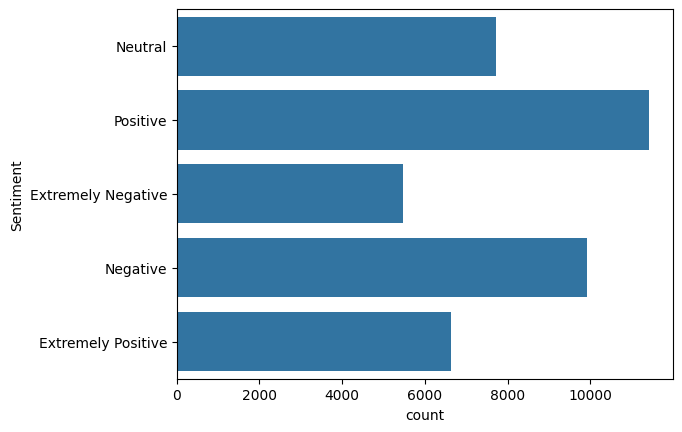

In [ ]:
sns.countplot(df['Sentiment'])

# ***DATASET PREPROCESSING***

### **1. SIMPLIFYING SENTIMENTS/LABEL MAPPING**

<Axes: xlabel='count', ylabel='Sentiment'>

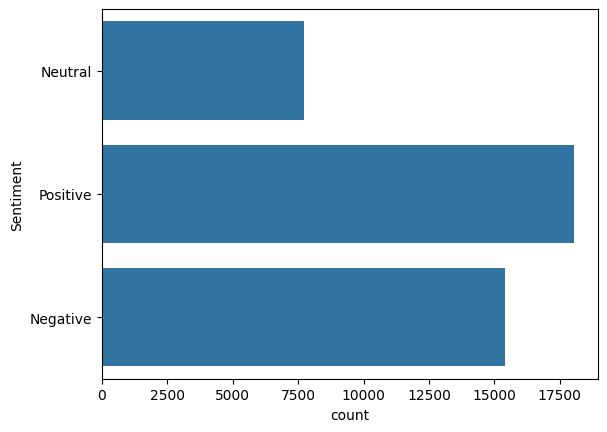

In [ ]:
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return "Positive"
    elif sentiment == "Extremely Negative":
        return "Negative"
    elif sentiment == "Positive":
        return "Positive"
    elif sentiment == "Negative":
        return "Negative"
    elif sentiment == "Neutral":
        return "Neutral"

df['Sentiment'] = df['Sentiment'].apply(lambda x: change_sen(x))
sns.countplot(df['Sentiment'])

### **2. REMOVING UNNECESSARY COLUMNS & DROPPING ROWS WITH NULL VALUES**

In [ ]:
df = df[['OriginalTweet','Sentiment']]
df = df.dropna(subset=['Sentiment'])
df = df.dropna(subset=['OriginalTweet'])
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Negative


### **3. ENCODE SENTIMENT LABELS  (CHECKPOINT)**

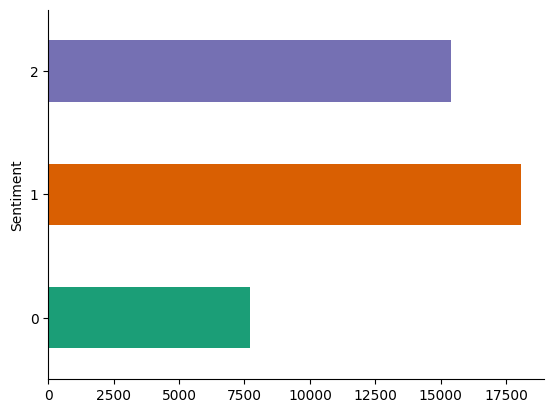

In [ ]:
df_train = df.copy()
l = {"Neutral":0, "Positive":1,"Negative":2}
df_train['Sentiment'] = df_train['Sentiment'].map(l)

df_train.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### **4. CLEANING DATA**

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
#nltk.download()
stop_word = stopwords.words('english')

def clean(text):
    #     remove urls
    text = re.sub(r'http\S+', " ", text)
    #     remove mentions
    text = re.sub(r'@\w+',' ',text)
    #     remove hastags
    text = re.sub(r'#\w+', ' ', text)
    #     remove digits
    text = re.sub(r'\d+', ' ', text)
    #     remove html tags
    text = re.sub('r<.*?>',' ', text)
    #     remove stop words
    text = text.split()
    text = " ".join([word for word in text if not word in stop_word])
    return text

df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(lambda x: clean(x))

### **5. LEMMATIZATION**

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for token in nltk.word_tokenize(text):
        lemma = lemmatizer.lemmatize(token)
        lemmatized_tokens.append(lemma)
    return ' '.join(lemmatized_tokens)

df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(lemmatize_text)
df_train.head()

,OriginalTweet,Sentiment
0,,0
1,advice Talk neighbour family exchange phone nu...,1
2,Coronavirus Australia : Woolworths give elderl...,1
3,"My food stock one empty ... PLEASE , panic , T...",1
4,"Me , ready go supermarket outbreak . Not I 'm ...",2


### **6. SPLITTING THE DATASET**

In [ ]:
X = df_train['OriginalTweet']
y = df_train['Sentiment']
X_train_, X_test, y_train_, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Training set shape:", X_train_.shape, y_train_.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (28809,) (28809,)
Testing set shape: (12348,) (12348,)


### **7. OVER-SAMPLING**

In [ ]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train_).reshape(-1, 1), y_train_)
y_train.value_counts()

Sentiment
2    12606
0    12606
1    12606
Name: count, dtype: int64

# **MODELS TRAINING**

## **ML MODELS TRAINING**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform([str(text) for text in X_train])
X_test_vectorized = vectorizer.transform([str(text) for text in X_test])

In [ ]:
#xgboost
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train_vectorized, y_train)
xgb_prediction = xgb_clf.predict(X_test_vectorized)
print(classification_report(xgb_prediction, y_test))
#saving model
model_path = '/content/drive/MyDrive/Lab Project/Trained/xgboost.joblib'
dump((xgb_clf, vectorizer), model_path)


              precision    recall  f1-score   support

           0       0.85      0.53      0.66      3661
           1       0.73      0.85      0.78      4682
           2       0.70      0.81      0.75      4005

    accuracy                           0.74     12348
   macro avg       0.76      0.73      0.73     12348
weighted avg       0.76      0.74      0.74     12348



['/content/drive/MyDrive/Lab Project/Trained/xgboost.joblib']

In [ ]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_vectorized, y_train)
rf_prediction = rf_clf.predict(X_test_vectorized)
print(classification_report(rf_prediction, y_test))
#saving model
model_path = '/content/drive/MyDrive/Lab Project/Trained/random_forest.joblib'
dump((rf_clf, vectorizer), model_path)


              precision    recall  f1-score   support

           0       0.73      0.64      0.68      2618
           1       0.79      0.78      0.79      5479
           2       0.72      0.79      0.75      4251

    accuracy                           0.75     12348
   macro avg       0.75      0.74      0.74     12348
weighted avg       0.75      0.75      0.75     12348



['/content/drive/MyDrive/Lab Project/Trained/random_forest.joblib']

In [ ]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_vectorized, y_train)
y_pred = logreg.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))
#saving model
model_path = '/content/drive/MyDrive/Lab Project/Trained/logistic_regression.joblib'
dump((logreg, vectorizer), model_path)

              precision    recall  f1-score   support

           0       0.61      0.81      0.70      2287
           1       0.86      0.80      0.83      5440
           2       0.84      0.78      0.80      4621

    accuracy                           0.79     12348
   macro avg       0.77      0.79      0.78     12348
weighted avg       0.80      0.79      0.79     12348



['/content/drive/MyDrive/Lab Project/Trained/logistic_regression.joblib']

In [ ]:
#Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()
naiveByes_clf.fit(X_train_vectorized, y_train)
NB_prediction = naiveByes_clf.predict(X_test_vectorized)
print(classification_report(NB_prediction,y_test))
#saving model
model_path = '/content/drive/MyDrive/Lab Project/Trained/naive_bayes_classifier.joblib'
dump((naiveByes_clf, vectorizer), model_path)

              precision    recall  f1-score   support

           0       0.57      0.62      0.60      2115
           1       0.76      0.75      0.75      5525
           2       0.74      0.73      0.73      4708

    accuracy                           0.72     12348
   macro avg       0.69      0.70      0.70     12348
weighted avg       0.72      0.72      0.72     12348



['/content/drive/MyDrive/Lab Project/Trained/naive_bayes_classifier.joblib']

In [ ]:
#SVM
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_vectorized, y_train)
svc_prediction = svc.predict(X_test_vectorized)
print(classification_report(svc_prediction,y_test))
#saving model
model_path = '/content/drive/MyDrive/Lab Project/Trained/SVM.joblib'
dump((svc, vectorizer), model_path)

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      2222
           1       0.84      0.82      0.83      5596
           2       0.80      0.82      0.81      4530

    accuracy                           0.80     12348
   macro avg       0.78      0.79      0.78     12348
weighted avg       0.80      0.80      0.80     12348



['/content/drive/MyDrive/Lab Project/Trained/SVM.joblib']

## **DL MODELS TRAINING**

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

BERT MODEL

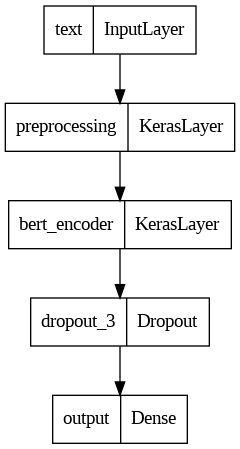

In [ ]:
bert_preprocess_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_model_encoder  = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1', trainable=True)
def build_bert_model():
  input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(bert_preprocess_model, name='preprocessing')
  encoder_inputs = preprocessing_layer(input_layer)
  encoder = hub.KerasLayer(bert_model_encoder, trainable=True, name='bert_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(3, activation='softmax', name="output")(net)
  return tf.keras.Model(input_layer, net)

bert_model = build_bert_model()
tf.keras.utils.plot_model(bert_model)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
bert_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
bert_training_history = bert_model.fit(train_dataset, epochs=3, validation_data=test_dataset)
# Save the model
model_path = '/content/drive/MyDrive/Lab Project/Trained/bert_model'
bert_model.save(model_path)

Epoch 1/3
1182/1182 [==============================] - 296s 243ms/step - loss: 0.6180 - accuracy: 0.7499 - val_loss: 0.4430 - val_accuracy: 0.8408
Epoch 2/3
1182/1182 [==============================] - 280s 236ms/step - loss: 0.3558 - accuracy: 0.8742 - val_loss: 0.4047 - val_accuracy: 0.8619
Epoch 3/3
1182/1182 [==============================] - 278s 235ms/step - loss: 0.2412 - accuracy: 0.9157 - val_loss: 0.4246 - val_accuracy: 0.8642


ELECTRA

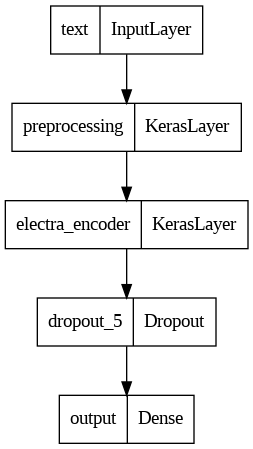

In [ ]:
electra_preprocess_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
electra_model_encoder  = hub.KerasLayer('https://tfhub.dev/google/electra_small/2', trainable=True)
def build_electra_model():
  input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(electra_preprocess_model, name='preprocessing')
  encoder_inputs = preprocessing_layer(input_layer)
  encoder = hub.KerasLayer(electra_model_encoder, trainable=True, name='electra_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(3, activation='softmax', name="output")(net)
  return tf.keras.Model(input_layer, net)

electra_model = build_electra_model()
tf.keras.utils.plot_model(electra_model)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
electra_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
electra_training_history = electra_model.fit(train_dataset, epochs=3, validation_data=test_dataset)
# Save the model
model_path = '/content/drive/MyDrive/Lab Project/Trained/electra_model'
electra_model.save(model_path)

Epoch 1/3
1182/1182 [==============================] - 473s 364ms/step - loss: 0.6231 - accuracy: 0.7503 - val_loss: 0.4381 - val_accuracy: 0.8463
Epoch 2/3
1182/1182 [==============================] - 462s 391ms/step - loss: 0.3857 - accuracy: 0.8668 - val_loss: 0.3789 - val_accuracy: 0.8735
Epoch 3/3
1182/1182 [==============================] - 422s 357ms/step - loss: 0.3100 - accuracy: 0.8924 - val_loss: 0.3700 - val_accuracy: 0.8856


# **EDA**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from joblib import dump, load

In [ ]:
loaded_logreg, loaded_vectorizer = load('/content/drive/MyDrive/Lab Project/Trained/logistic_regression.joblib')
X_test_vectorized = loaded_vectorizer.transform([str(text) for text in X_test])
y_pred_logreg = loaded_logreg.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred_logreg)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred_logreg, average='weighted')
print("Precision:", precision)


recall = recall_score(y_test, y_pred_logreg, average='weighted')
print("Recall:", recall)


print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))


conf_matrix = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix:")
print(conf_matrix)


logreg_results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'classification_report': classification_report(y_test, y_pred_logreg),
    'confusion_matrix': conf_matrix
}


Accuracy: 0.7906543569808876
Precision: 0.8046548683567956
Recall: 0.7906543569808876
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.81      0.70      2287
           1       0.86      0.80      0.83      5440
           2       0.84      0.78      0.80      4621

    accuracy                           0.79     12348
   macro avg       0.77      0.79      0.78     12348
weighted avg       0.80      0.79      0.79     12348

Confusion Matrix:
[[1850  210  227]
 [ 632 4330  478]
 [ 538  500 3583]]


In [ ]:
loaded_xgboost, loaded_vectorizer = load('/content/drive/MyDrive/Lab Project/Trained/xgboost.joblib')
X_test_vectorized = loaded_vectorizer.transform([str(text) for text in X_test])
y_pred_xgboost = loaded_xgboost.predict(X_test_vectorized)


accuracy = accuracy_score(y_test, y_pred_xgboost)
print("Accuracy:", accuracy)


precision = precision_score(y_test, y_pred_xgboost, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, y_pred_xgboost, average='weighted')
print("Recall:", recall)

print("Classification Report:")
print(classification_report(y_test, y_pred_xgboost))

conf_matrix = confusion_matrix(y_test, y_pred_xgboost)
print("Confusion Matrix:")
print(conf_matrix)


xgboost_results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'classification_report': classification_report(y_test, y_pred_xgboost),
    'confusion_matrix': conf_matrix
}


Accuracy: 0.7426303854875284
Precision: 0.7758492045518282
Recall: 0.7426303854875284
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.85      0.66      2287
           1       0.85      0.73      0.78      5440
           2       0.81      0.70      0.75      4621

    accuracy                           0.74     12348
   macro avg       0.73      0.76      0.73     12348
weighted avg       0.78      0.74      0.75     12348

Confusion Matrix:
[[1951  153  183]
 [ 907 3965  568]
 [ 803  564 3254]]


In [ ]:
loaded_random_forest, loaded_vectorizer = load('/content/drive/MyDrive/Lab Project/Trained/random_forest.joblib')
X_test_vectorized = loaded_vectorizer.transform([str(text) for text in X_test])
y_pred_random_forest = loaded_random_forest.predict(X_test_vectorized)


accuracy = accuracy_score(y_test, y_pred_random_forest)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred_random_forest, average='weighted')
print("Precision:", precision)


recall = recall_score(y_test, y_pred_random_forest, average='weighted')
print("Recall:", recall)


print("Classification Report:")
print(classification_report(y_test, y_pred_random_forest))

conf_matrix = confusion_matrix(y_test, y_pred_random_forest)
print("Confusion Matrix:")
print(conf_matrix)


random_forest_results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'classification_report': classification_report(y_test, y_pred_random_forest),
    'confusion_matrix': conf_matrix
}


Accuracy: 0.75348234531908
Precision: 0.7574506728920316
Recall: 0.75348234531908
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.73      0.68      2287
           1       0.78      0.79      0.79      5440
           2       0.79      0.72      0.75      4621

    accuracy                           0.75     12348
   macro avg       0.74      0.75      0.74     12348
weighted avg       0.76      0.75      0.75     12348

Confusion Matrix:
[[1670  344  273]
 [ 508 4294  638]
 [ 440  841 3340]]


In [ ]:
loaded_naive_bayes_classifier, loaded_vectorizer = load('/content/drive/MyDrive/Lab Project/Trained/naive_bayes_classifier.joblib')
X_test_vectorized = loaded_vectorizer.transform([str(text) for text in X_test])
y_pred_naive_bayes_classifier = loaded_naive_bayes_classifier.predict(X_test_vectorized)


accuracy = accuracy_score(y_test, y_pred_naive_bayes_classifier)
print("Accuracy:", accuracy)


precision = precision_score(y_test, y_pred_naive_bayes_classifier, average='weighted')
print("Precision:", precision)


recall = recall_score(y_test, y_pred_naive_bayes_classifier, average='weighted')
print("Recall:", recall)

print("Classification Report:")
print(classification_report(y_test, y_pred_naive_bayes_classifier))


conf_matrix = confusion_matrix(y_test, y_pred_naive_bayes_classifier)
print("Confusion Matrix:")
print(conf_matrix)

naive_bayes_classifier_results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'classification_report': classification_report(y_test, y_pred_naive_bayes_classifier),
    'confusion_matrix': conf_matrix
}


Accuracy: 0.7185779073534175
Precision: 0.7169473170052294
Recall: 0.7185779073534175
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.57      0.60      2287
           1       0.75      0.76      0.75      5440
           2       0.73      0.74      0.73      4621

    accuracy                           0.72     12348
   macro avg       0.70      0.69      0.70     12348
weighted avg       0.72      0.72      0.72     12348

Confusion Matrix:
[[1313  540  434]
 [ 460 4133  847]
 [ 342  852 3427]]


In [ ]:
loaded_SVM, loaded_vectorizer = load('/content/drive/MyDrive/Lab Project/Trained/SVM.joblib')
X_test_vectorized = loaded_vectorizer.transform([str(text) for text in X_test])
y_pred_SVM = loaded_SVM.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred_SVM)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred_SVM, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, y_pred_SVM, average='weighted')
print("Recall:", recall)

print("Classification Report:")
print(classification_report(y_test, y_pred_SVM))

conf_matrix = confusion_matrix(y_test, y_pred_SVM)
print("Confusion Matrix:")
print(conf_matrix)

SVM_results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'classification_report': classification_report(y_test, y_pred_SVM),
    'confusion_matrix': conf_matrix
}


Accuracy: 0.8013443472627146
Precision: 0.8008031335532528
Recall: 0.8013443472627146
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71      2287
           1       0.82      0.84      0.83      5440
           2       0.82      0.80      0.81      4621

    accuracy                           0.80     12348
   macro avg       0.79      0.78      0.78     12348
weighted avg       0.80      0.80      0.80     12348

Confusion Matrix:
[[1594  393  300]
 [ 335 4588  517]
 [ 293  615 3713]]


In [ ]:
from tensorflow.keras.models import load_model
loaded_bert_model = load_model('/content/drive/MyDrive/Lab Project/Trained/bert_model')
y_pred_bert = loaded_bert_model.predict(X_test)
y_pred_bert_class = y_pred_bert.argmax(axis=1)
accuracy = accuracy_score(y_test, y_pred_bert_class)
precision = precision_score(y_test, y_pred_bert_class, average='weighted')
recall = recall_score(y_test, y_pred_bert_class, average='weighted')
classification_rep = classification_report(y_test, y_pred_bert_class)
conf_matrix = confusion_matrix(y_test, y_pred_bert_class)
bert_results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'classification_report': classification_rep,
    'confusion_matrix': conf_matrix
}
print("Bert Results:")
for key, value in bert_results.items():
    print(f"{key}: {value}")


386/386 [==============================] - 968s 3s/step
Bert Results:
accuracy: 0.8641885325558795
precision: 0.8652467863604086
recall: 0.8641885325558795
classification_report:               precision    recall  f1-score   support

           0       0.79      0.83      0.81      2287
           1       0.90      0.87      0.88      5440
           2       0.86      0.88      0.87      4621

    accuracy                           0.86     12348
   macro avg       0.85      0.86      0.85     12348
weighted avg       0.87      0.86      0.86     12348

confusion_matrix: [[1887  191  209]
 [ 252 4735  453]
 [ 237  335 4049]]


In [ ]:
from tensorflow.keras.models import load_model
loaded_electra_model = load_model('/content/drive/MyDrive/Lab Project/Trained/electra_model')
y_pred_electra = loaded_electra_model.predict(X_test)
y_pred_electra_class = y_pred_electra.argmax(axis=1)
accuracy = accuracy_score(y_test, y_pred_electra_class)
precision = precision_score(y_test, y_pred_electra_class, average='weighted')
recall = recall_score(y_test, y_pred_electra_class, average='weighted')
classification_rep = classification_report(y_test, y_pred_electra_class)
conf_matrix = confusion_matrix(y_test, y_pred_electra_class)
electra_results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'classification_report': classification_rep,
    'confusion_matrix': conf_matrix
}
print("Electra Results:")
for key, value in electra_results.items():
    print(f"{key}: {value}")


386/386 [==============================] - 836s 2s/step
Electra Results:
accuracy: 0.8856494978943958
precision: 0.8859008490200736
recall: 0.8856494978943958
classification_report:               precision    recall  f1-score   support

           0       0.87      0.83      0.85      2287
           1       0.91      0.89      0.90      5440
           2       0.87      0.90      0.89      4621

    accuracy                           0.89     12348
   macro avg       0.88      0.88      0.88     12348
weighted avg       0.89      0.89      0.89     12348

confusion_matrix: [[1905  203  179]
 [ 136 4856  448]
 [ 140  306 4175]]


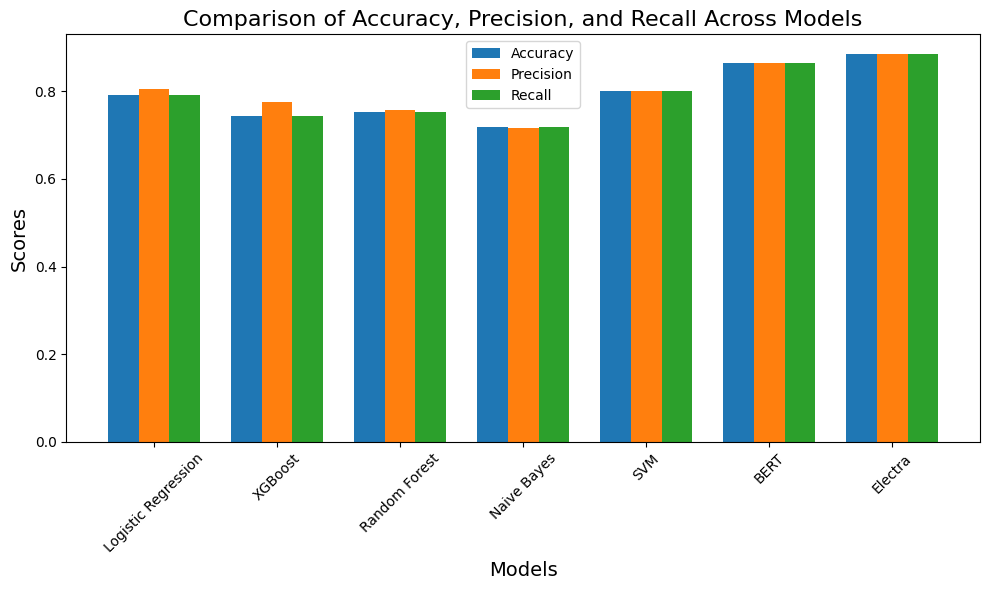

In [ ]:
models = ['Logistic Regression', 'XGBoost', 'Random Forest', 'Naive Bayes', 'SVM', 'BERT', 'Electra']
accuracies = [logreg_results['accuracy'], xgboost_results['accuracy'], random_forest_results['accuracy'],
              naive_bayes_classifier_results['accuracy'], SVM_results['accuracy'], bert_results['accuracy'],
              electra_results['accuracy']]
precisions = [logreg_results['precision'], xgboost_results['precision'], random_forest_results['precision'],
              naive_bayes_classifier_results['precision'], SVM_results['precision'], bert_results['precision'],
              electra_results['precision']]
recalls = [logreg_results['recall'], xgboost_results['recall'], random_forest_results['recall'],
           naive_bayes_classifier_results['recall'], SVM_results['recall'], bert_results['recall'],
           electra_results['recall']]

plt.figure(figsize=(10, 6))
bar_width = 0.25
index = range(len(models))
plt.bar(index, accuracies, bar_width, label='Accuracy')
plt.bar([i + bar_width for i in index], precisions, bar_width, label='Precision')
plt.bar([i + bar_width * 2 for i in index], recalls, bar_width, label='Recall')


plt.xlabel('Models', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Comparison of Accuracy, Precision, and Recall Across Models', fontsize=16)
plt.xticks([i + bar_width for i in index], models, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


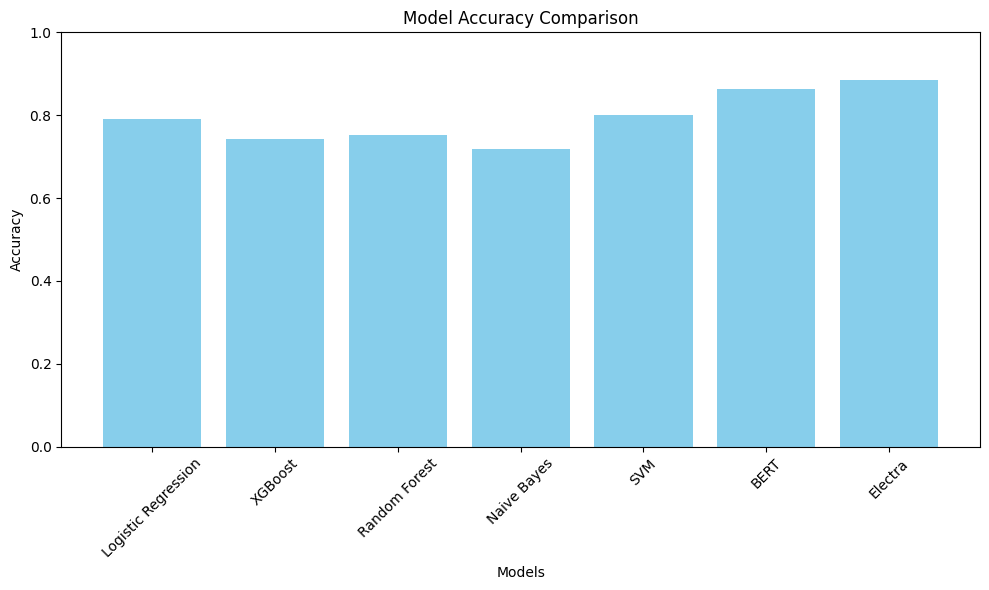

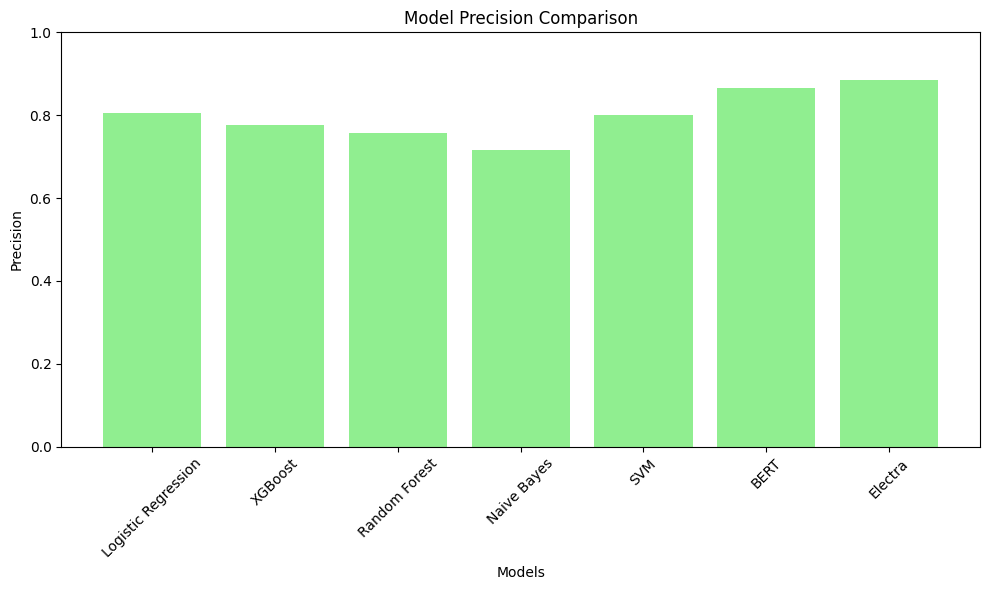

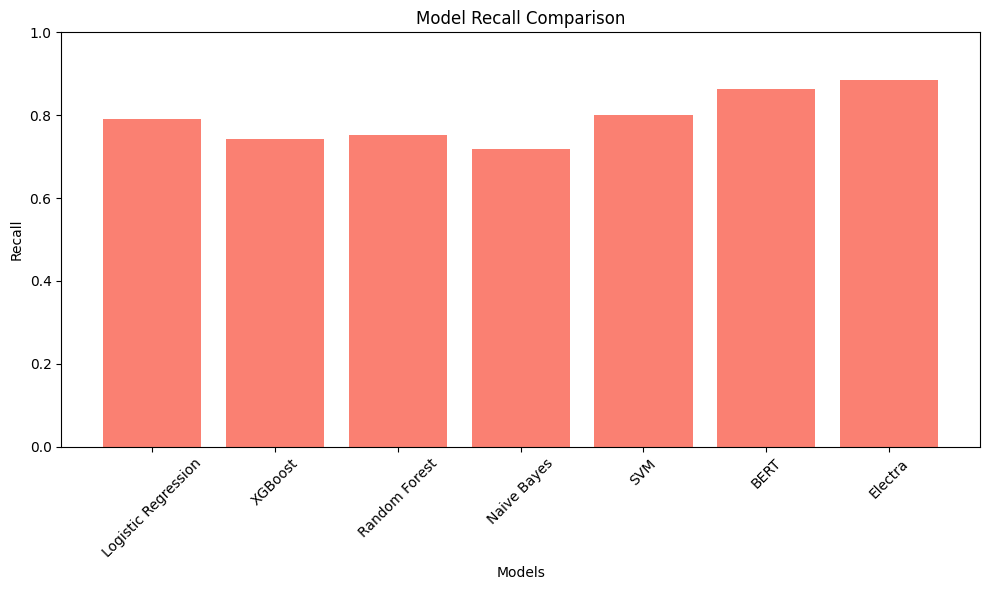

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Plotting Precision
plt.figure(figsize=(10, 6))
plt.bar(models, precisions, color='lightgreen')
plt.title('Model Precision Comparison')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Plotting Recall
plt.figure(figsize=(10, 6))
plt.bar(models, recalls, color='salmon')
plt.title('Model Recall Comparison')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

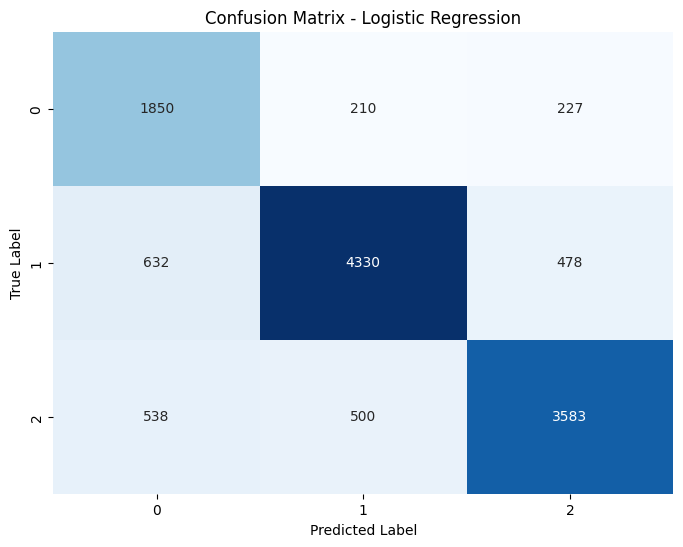

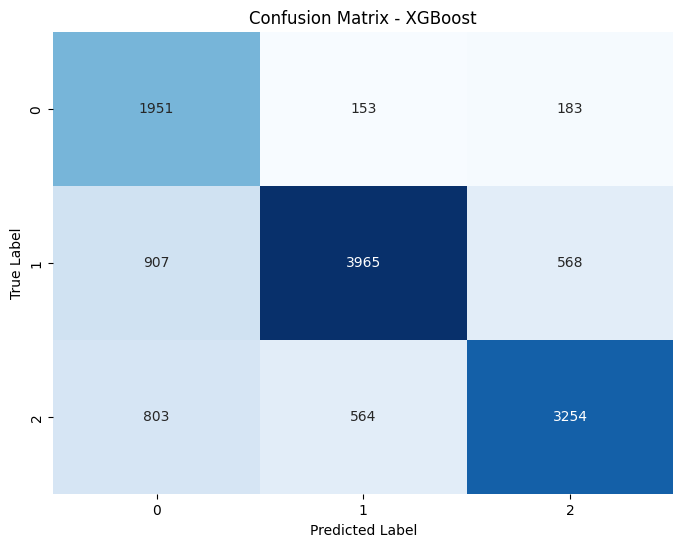

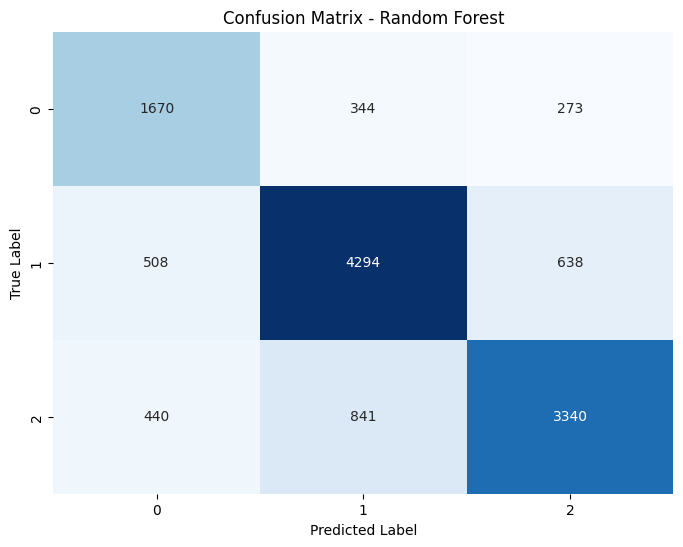

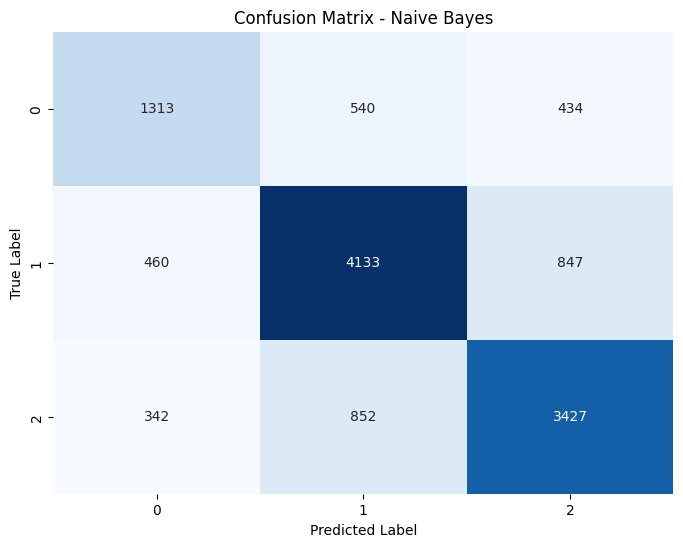

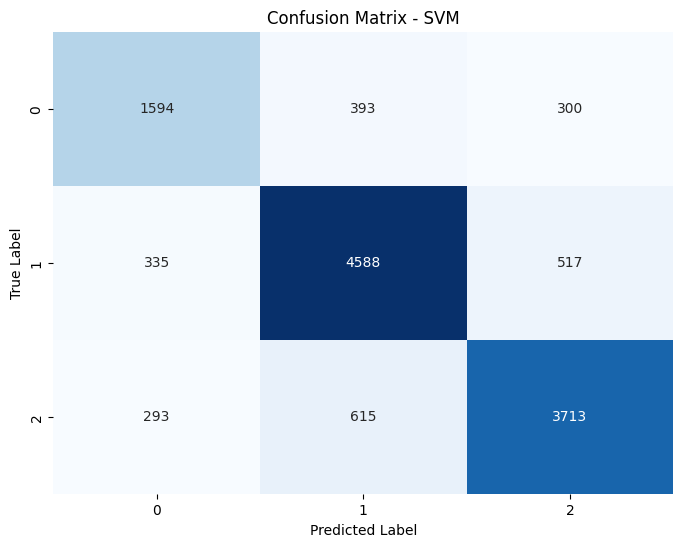

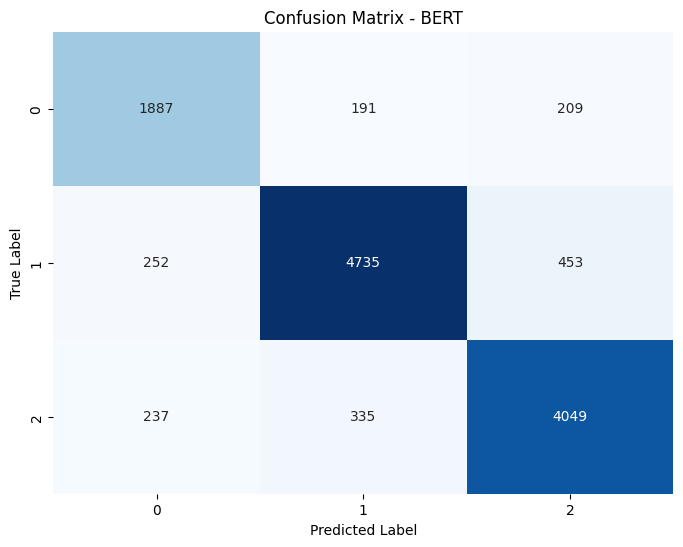

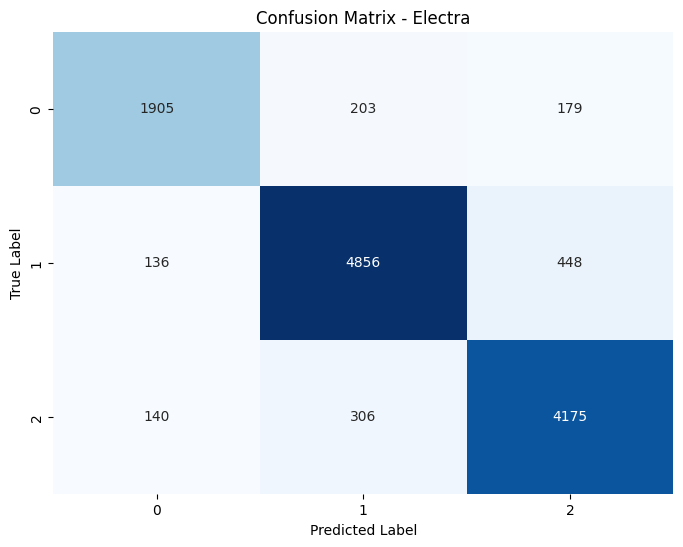

In [ ]:
confusion = [logreg_results['confusion_matrix'], xgboost_results['confusion_matrix'], random_forest_results['confusion_matrix'],
              naive_bayes_classifier_results['confusion_matrix'], SVM_results['confusion_matrix'], bert_results['confusion_matrix'],
              electra_results['confusion_matrix']]
models = ['Logistic Regression', 'XGBoost', 'Random Forest', 'Naive Bayes', 'SVM', 'BERT', 'Electra']

for i, confusion_matrix in enumerate(confusion):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {models[i]}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()